In [12]:

import numpy as np

import matplotlib.pyplot as plt
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150
import tenpy

from tenpy.algorithms import dmrg
from tenpy.networks.mps import MPS

from model_isingselfdual import TFISDModel

from scipy.optimize import curve_fit

tenpy.tools.misc.setup_logging(to_stdout="INFO")


In [13]:
# Parameters 

L = 30
chiMax = 700


model_params = {
    'p': 0.3 , 'lambda': 1.,  # for lambda=1 and p "small enough" the model should be critical
    'L': L,
    'bc_MPS': 'finite',
}

M = TFISDModel(model_params)

INFO    : TFISDModel: reading 'bc_MPS'='finite'
INFO    : TFISDModel: reading 'L'=30
INFO    : TFISDModel: reading 'p'=0.3
INFO    : TFISDModel: reading 'lambda'=1.0


In [14]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

#Run DMRG 

dmrg_params = {
    'mixer': None,  # setting this to True helps to escape local minima
    'max_E_err': 1.e-10,
    'trunc_params': {
        'chi_max': chiMax,
        'svd_min': 1.e-10,
    },
    'combine': True
}

engine = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)

E, psi = engine.run() # the main work; modifies psi in place

INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : TwoSiteDMRGEngine: reading 'combine'=True
INFO    : TwoSiteDMRGEngine: reading 'max_E_err'=1e-10
INFO    : TwoSiteDMRGEngine: reading 'mixer'=None
INFO    : Running sweep with optimization
INFO    : trunc_params: reading 'chi_max'=700
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : checkpoint after sweep 1
energy=-28.5864226006742577, max S=0.2938259200319839, age=30, norm_err=1.5e-02
Current memory usage 429568.0MB, wall time: 1.3s
Delta E = nan, Delta S = 2.8202e-01 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 2.4869e-14
chi: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
INFO    : Running sweep with optimization
INFO    : checkpoint after sweep 2
energy=-28.6282349952273627, max S=0.8229660523465452, age=30, norm_err=6.1e-01
Current memory usage 429568.0MB, wall time: 2.1s
Delta E = -4.1812e-02, Delta S = 2.5413e-01 (per swee

In [15]:
# E is the ground state energy directly returned by dmrg.run()

# there are other ways to extract the energy from psi:
E1 = M.H_MPO.expectation_value(psi)  # based on the MPO

print("ground state energy = ", E, E1)

#E2 = np.sum(M.bond_energies(psi))  # based on bond terms of H, works only for a NearestNeighborModel
assert abs(E-E1) < 1.e-10


ground state energy =  -28.636150741485984 -28.63615074148603


In [16]:
#Bond dimensions
print(psi.chi)

[2, 4, 8, 16, 32, 64, 95, 120, 143, 166, 187, 205, 218, 226, 230, 226, 218, 205, 187, 166, 144, 120, 95, 64, 32, 16, 8, 4, 2]


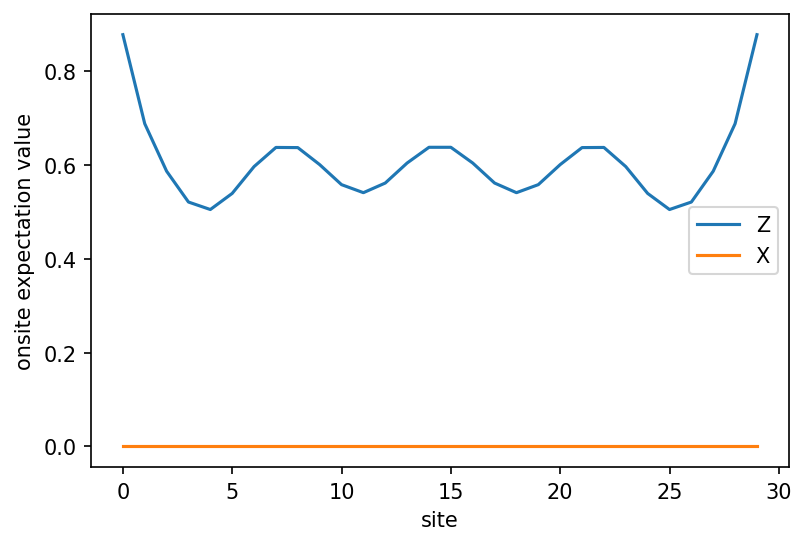

In [17]:


# onsite expectation values

X = psi.expectation_value("Sigmax")
Z = psi.expectation_value("Sigmaz")
x = np.arange(psi.L)
plt.figure()
plt.plot(x, Z, label="Z")
plt.plot(x, X, label="X")   # note: it's clear that this is zero due to charge conservation!
plt.xlabel("site")
plt.ylabel("onsite expectation value")
plt.legend()
plt.show()

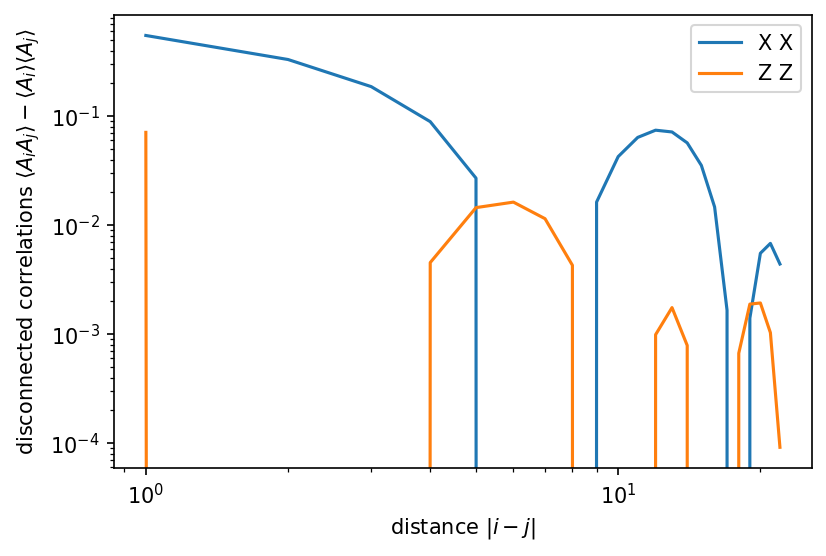

In [18]:
# correlation functions

i0 = psi.L // 4  # for fixed `i`
j = np.arange(i0 + 1, psi.L)
XX = psi.term_correlation_function_right([("Sigmax", 0)], [("Sigmax", 0)], i_L=i0, j_R=j)
XX_disc = XX - X[i0] * X[j]
ZZ = psi.term_correlation_function_right([("Sigmaz", 0)], [("Sigmaz", 0)], i_L=i0, j_R=j)
ZZ_disc = ZZ - Z[i0] * Z[j]

dx = j - i0
plt.figure()
plt.plot(dx, XX_disc, label="X X")
plt.plot(dx, ZZ_disc, label="Z Z")
plt.xlabel(r"distance $|i-j|$")
plt.ylabel(r"disconnected correlations $\langle A_i A_j\rangle - \langle A_i \rangle\langle A_j\rangle$")
plt.legend()
plt.loglog()
plt.show()

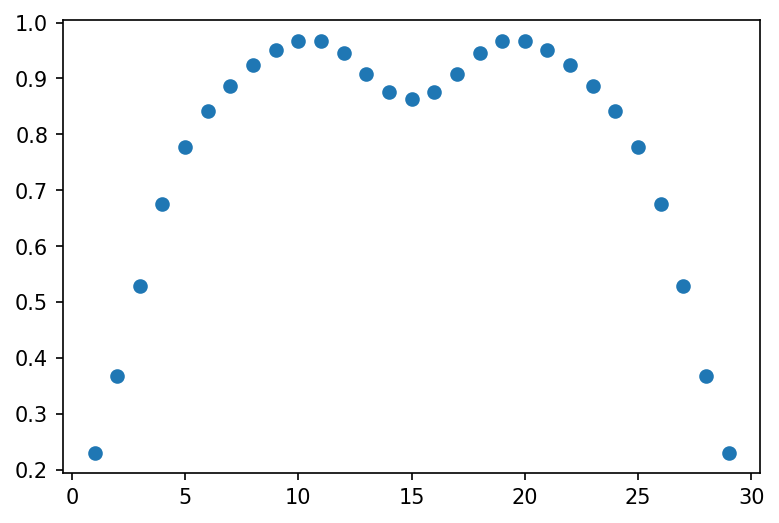

In [19]:
bonds = range(1,L)
entrop = psi.entanglement_entropy()
plt.figure()
plt.scatter(bonds,entrop)

[-5.56535 17.84351]
 
-0.9276 x + 2.974
-0.9526690198068102


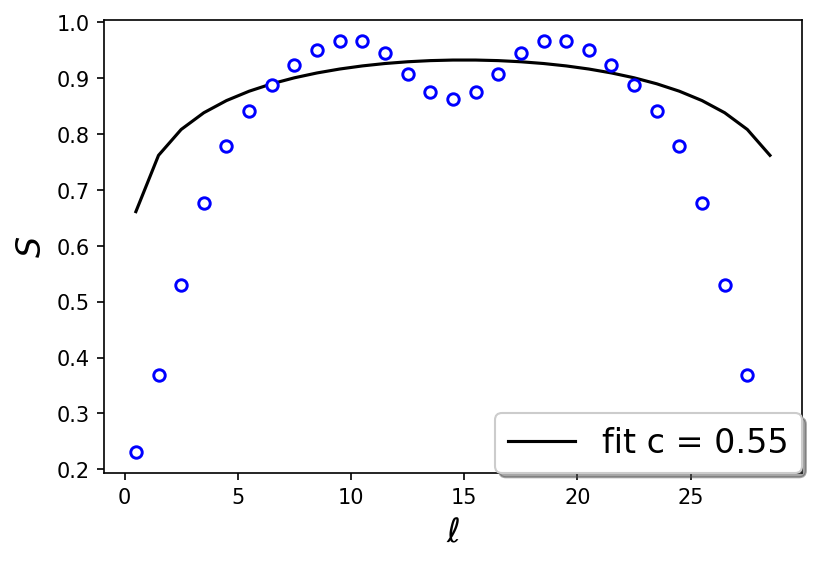

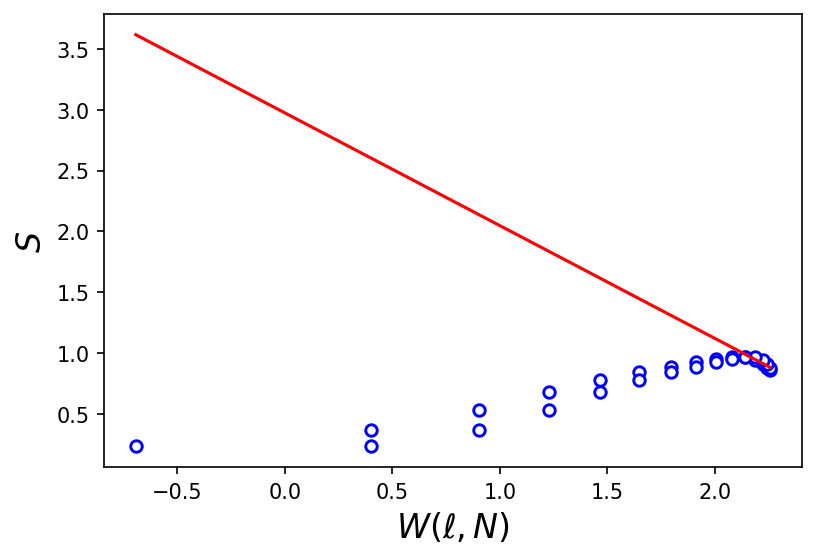

In [20]:


# Fit the central charge "c" against the CFT prediction

def fitFunc(x, c, a):
        return (c / 6) * np.log(L/np.pi * np.sin(np.pi*x/L)) + a

ell= np.arange(0.5, L-1)
entropies= np.array(entrop)

w_l_L = [np.log(L/np.pi*np.sin(np.pi*ell[k]/L)) for k in range(0,len(ell))]

fitParams, fitCovariances = curve_fit(fitFunc,ell[5:-5] ,entropies[5:-5])

plt.errorbar(ell,
                 entropies,
                 fmt='o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)

plt.plot(ell,
             fitFunc(ell, fitParams[0], fitParams[1]),
             linewidth=1.5,
             c='black',
             label='fit c = {c:.2f}'.format(c = fitParams[0]))

plt.xlabel(r'$\ell$', fontsize=16)
plt.ylabel(r'$S$', fontsize=16)

plt.legend(loc='lower right', borderaxespad=0., fancybox=True, shadow=True, fontsize=16)

fig_ent= plt.figure()

plt.plot(w_l_L,entropies, 'o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4 )

plt.xlabel(r'$W(\ell,N)$', fontsize=16)
plt.ylabel(r'$S$', fontsize=16)

z2= np.polyfit(w_l_L[10:-10], entropies[10:-10], 1)
p2=np.poly1d(z2)

plt.plot(np.linspace(np.min(w_l_L),np.max(w_l_L)),p2(np.linspace(np.min(w_l_L),np.max(w_l_L))),'-',color='red')

print(z2*6)
print(p2)

central_charge, const, res = tenpy.tools.fit.central_charge_from_S_profile(psi)
print(central_charge)

Text(0, 0.5, '$\\Delta_i/\\Delta_j$')

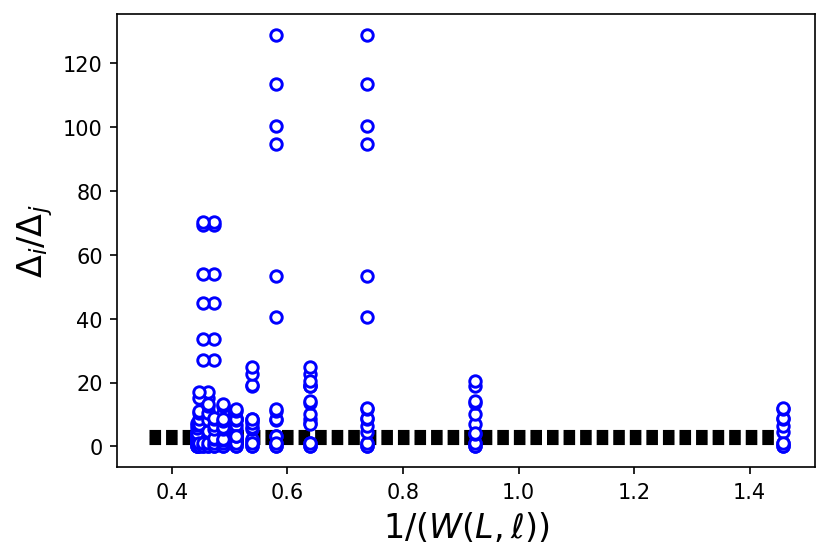

In [21]:
spectrum = psi.entanglement_spectrum()

#ent_gaps=[spectrum[k]-spectrum[k][0] for k in  range(len(spectrum))]
ent_gaps = [lam - lam[0] for lam in spectrum]

#ent_ratios=[ent_gaps[k][0:10]/ent_gaps[k][1] for k in  range(len(spectrum))]
ent_ratios = [rr[0:8]/rr[1] for rr in ent_gaps]

for pos in range(2,L-1):
    elle=1./(np.log(L/np.pi*np.sin(np.pi*float(pos)/L)))*np.ones(len(ent_ratios[pos]))
    plt.errorbar(elle,
                 ent_ratios[pos],
                 fmt='o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)

plt.hlines([1,2,3,4,5],
     1./np.log(L/2+1), 1./np.log(2), colors='k', linestyles='dashed')

#plt.hlines([3.5],   1./np.log(L/2+1),  1./np.log(2), colors='r', linestyles='dashed')

plt.xlabel(r'$1/(W(L,\ell))$', fontsize=16)
plt.ylabel(r'$\Delta_i/\Delta_j$', fontsize=16)

IndexError: index 2 is out of bounds for axis 0 with size 2

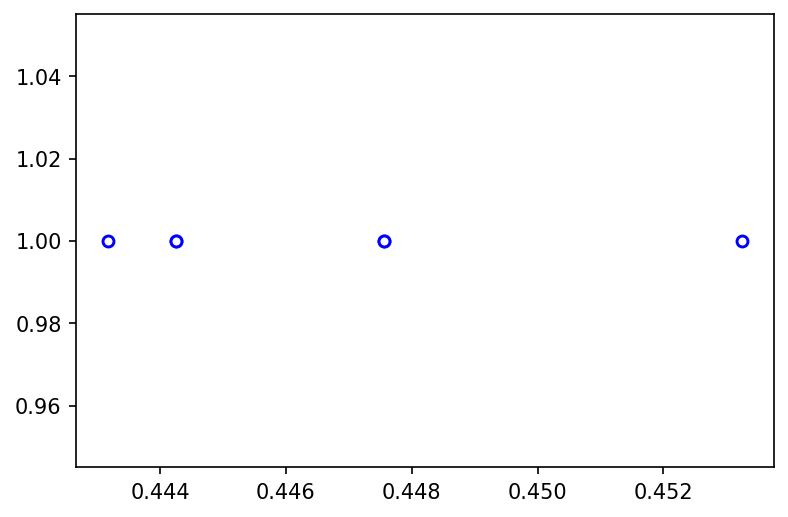

In [22]:
low=12
high=L-low

fig = plt.figure()
for num_ratio in range(1,5):
    first_ratio=[ent_ratios[k][num_ratio] for k in  range(low,high) ]
#p=range(1,len(spectrum))
#inverse_log=[1./np.log((np.float(k))) for k in range(2,L-1)]
    inverse_log=[1./(np.log(L/np.pi*np.sin(np.pi*float(k)/L))) for k in range(low,high)]
    #def quadfit(x, a, b,c):
    #        return a*x*x+b*x+c
    
    z = np.polyfit(inverse_log, first_ratio, 2)
    p = np.poly1d(z)
    #fitParams, fitCovariances = curve_fit(quadfit,inverse_log ,first_ratio)
    

    plt.plot(inverse_log, first_ratio,'.',
                 c='blue',
                 ms=10.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4)

#plt.plot(np.linspace(0.2,1.4,100),
 #            quadfit(np.linspace(0,0.3,100), fitParams[0], fitParams[1], fitParams[2]),
  #           linewidth=1.5,
   #          c='black',
    #         label='fit c = {c:.2f}'.format(c = fitParams[2]))
    plt.plot(np.linspace(0.,1.5,100), p(np.linspace(0.,1.5,100)),'-',
                 c='red',
                 markeredgewidth=1.4,
    label='fit c = {c:.2f}'.format(c = fitParams[2]))
   # fitParams[2]
   # plt.legend(loc='lower right', borderaxespad=0., fancybox=True, shadow=True, fontsize=16)

plt.hlines([1,2,3,4,5],
    0, 1./np.log(2), colors='k', linestyles='dashed')
#plt.hlines([3.5],
  #    0,  1./np.log(2), colors='r', linestyles='dashed')
plt.xlabel(r'$1/W(\ell,N)$', fontsize=16)
plt.xlim([0,0.6])
plt.ylim([0,8])
plt.ylabel(r'$r_j$', fontsize=16)
#ax2 = plt.axes([0,0,1,1])
plt.tight_layout()
ax2=fig.add_axes([0.72, 0.7, 0.25, 0.25]) 

ax2.plot(w_l_L,entropies, 'o',
                 c='blue',
                 ms=5.5,
                 markerfacecolor='white',
                 markeredgecolor='blue',
                 markeredgewidth=1.4 )

ax2.set_xlabel(r'$W$', fontsize=16)
ax2.set_ylabel(r'$S$', fontsize=16)

ax2.plot(np.linspace(np.min(w_l_L),np.max(w_l_L)),p2(np.linspace(np.min(w_l_L),np.max(w_l_L))),'-',color='red')